# Part 4 - Morphology and Segmentation

## Basic morphology operations with scikit-image

In [1]:
from skimage import io, color, util, filters
from skimage import exposure, transform, morphology, measure
import numpy as np
import matplotlib

/anaconda3/envs/ImPyClass2/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda3/envs/ImPyClass2/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/envs/ImPyClass2/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


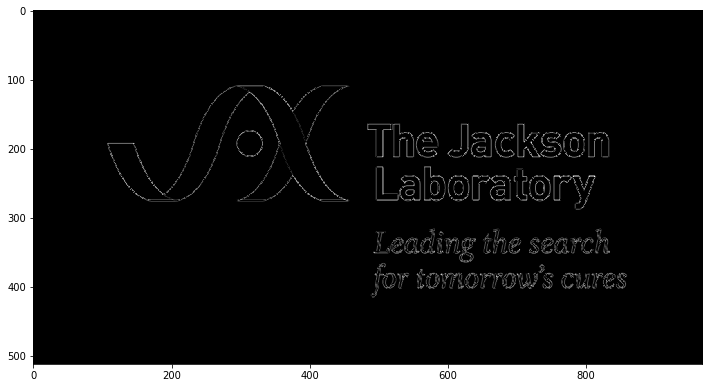

In [3]:
# Lets get our edge map back (see Part 3 for explanation of this code)
jax = io.imread('data/jax.jpeg')
jax = transform.rescale(jax, .5)
jax_gray = color.rgb2gray(jax)
jax_gray = util.invert(jax_gray)
jax_edges = filters.laplace(jax_gray)

jax_edges = abs(jax_edges)
jax_edges = exposure.rescale_intensity(jax_edges, in_range='image', out_range='uint8')
jax_edges = jax_edges.astype('uint8')

matplotlib.rcParams['figure.figsize'] = [10.0, 10.0] 
io.imshow(jax_edges);

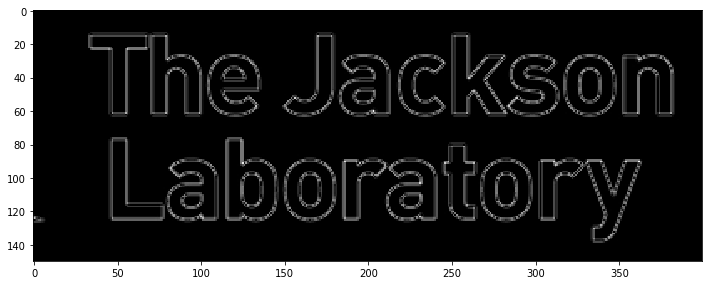

In [4]:
io.imshow(jax_edges[150:300, 450:850]);

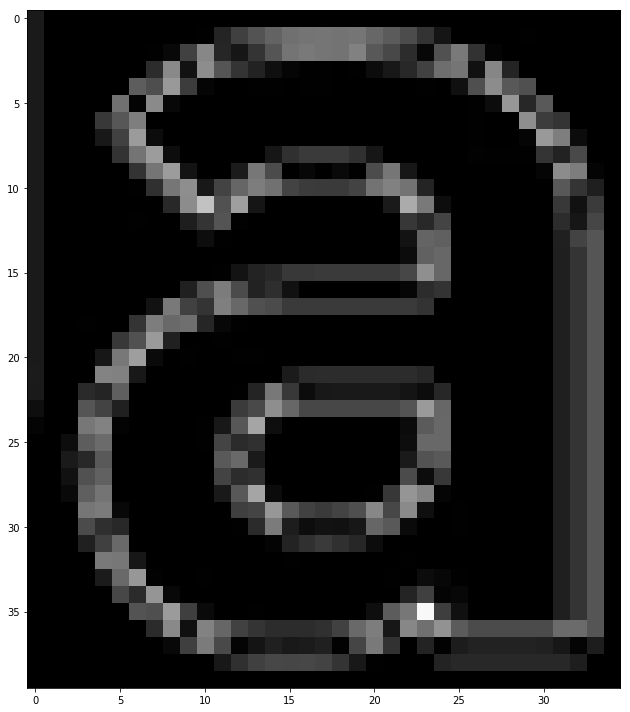

In [5]:
io.imshow(jax_edges[175:215, 630:665]);

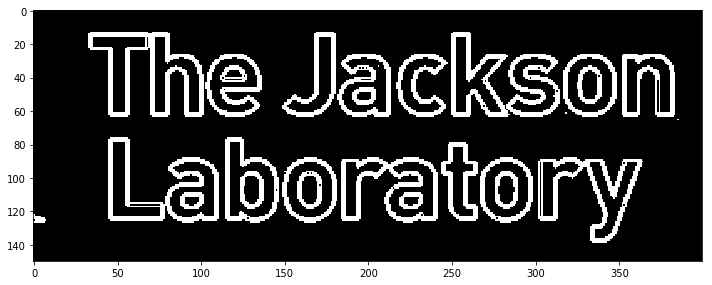

In [6]:
# We can produce a binary image by evaluating a conditional statement

jax_outline = jax_edges > 1
io.imshow(jax_outline[150:300, 450:850]);

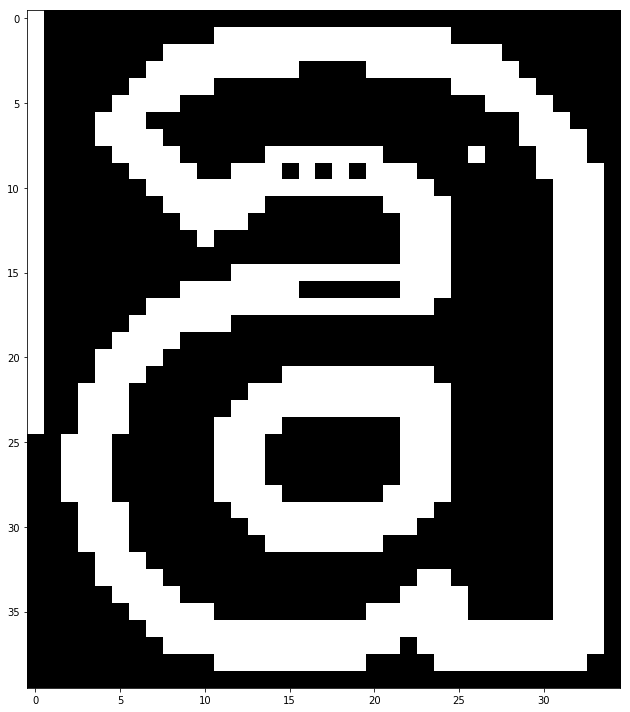

In [7]:
# ...but it is a little messy
io.imshow(jax_outline[175:215, 630:665]);

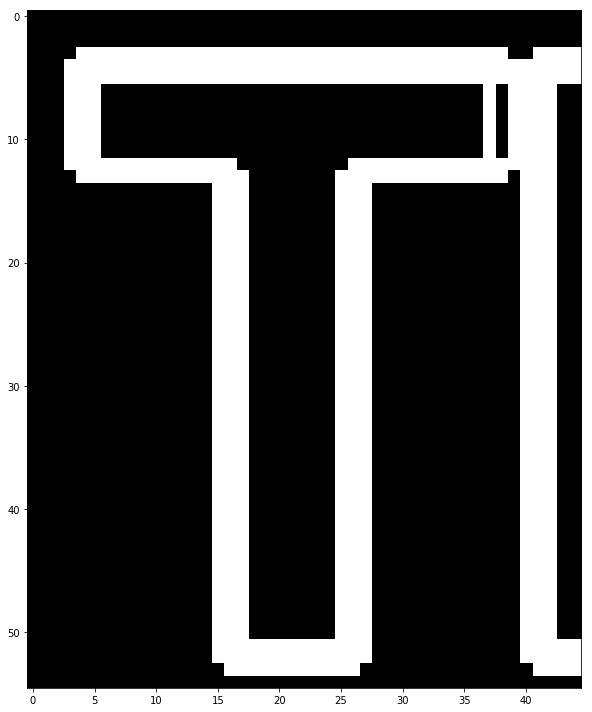

In [8]:
io.imshow(jax_outline[160:215, 480:525]);

In [9]:
# Note that this is actually a boolean array
jax_outline[175:215, 630:665]

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

--------
## Slides covering dilation and erosion
--------

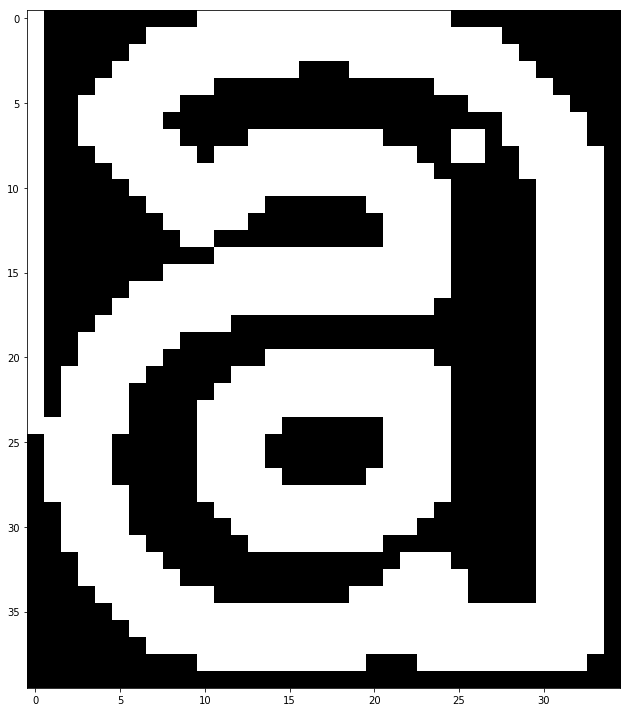

In [10]:
# First we need to create a structuring element ("selem")
selem = morphology.square(2)

# Now use the structuring element to dilate
jax_outline_dilate =  morphology.binary_dilation(jax_outline, selem = selem)
io.imshow(jax_outline_dilate[175:215, 630:665]);

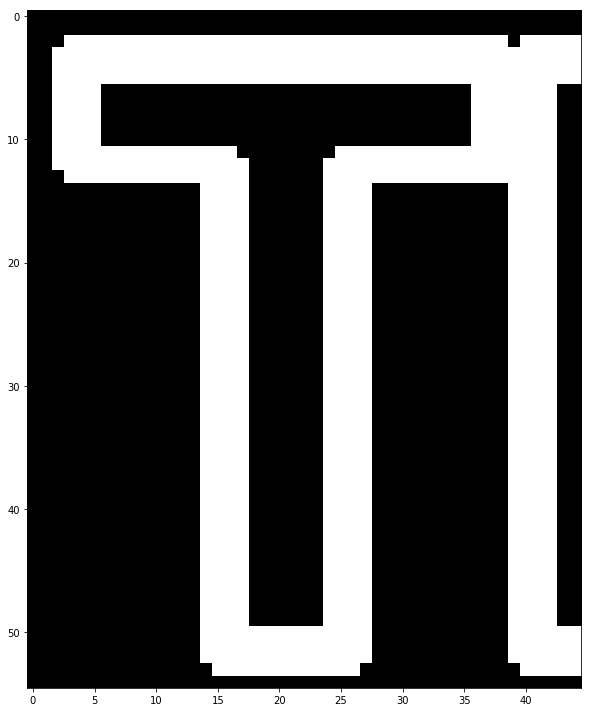

In [11]:
io.imshow(jax_outline_dilate[160:215, 480:525]);

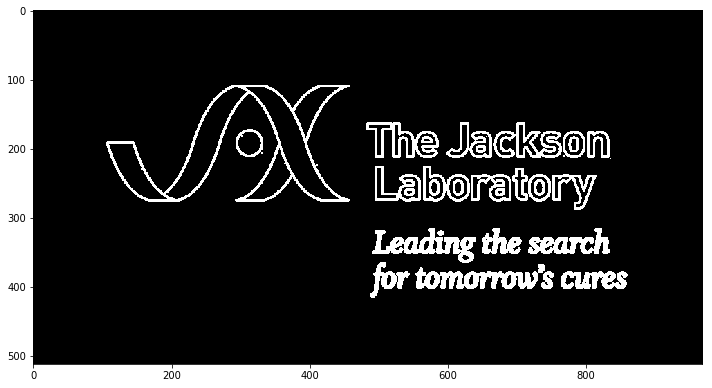

In [12]:
io.imshow(jax_outline_dilate);

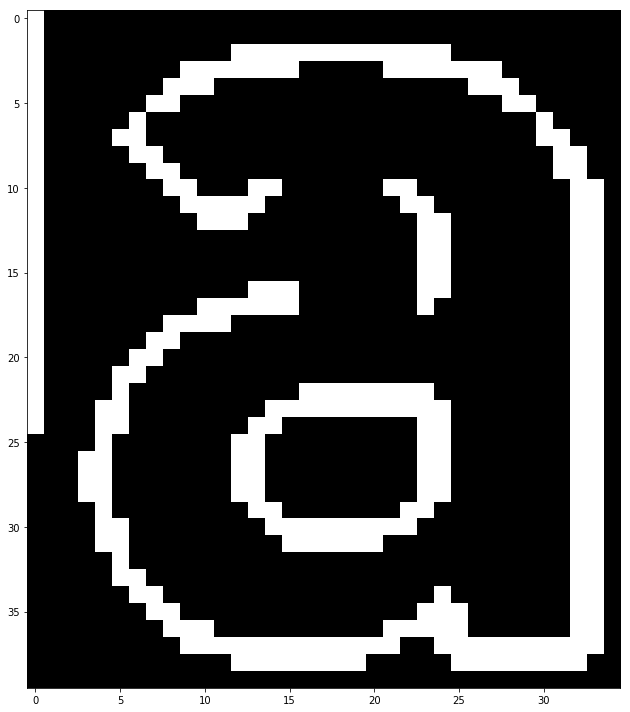

In [13]:
# What would have erosion done?

jax_outline_erode =  morphology.binary_erosion(jax_outline, selem = selem)
io.imshow(jax_outline_erode[175:215, 630:665]);

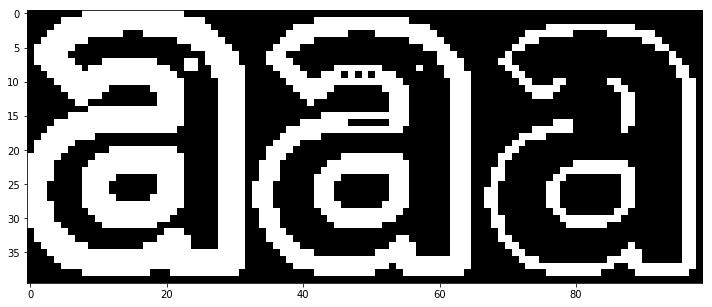

In [14]:
# Lets compare all three operations

image_row_1 = jax_outline_dilate[175:215, 632:665]
image_row_2 = jax_outline[175:215, 632:665]
image_row_3 = jax_outline_erode[175:215, 632:665]

image_row = np.hstack((image_row_1, image_row_2, image_row_3))

io.imshow(image_row);


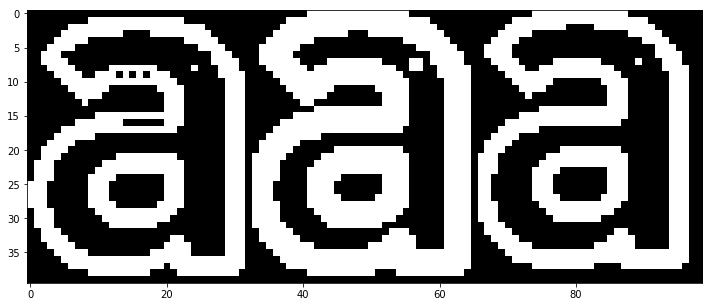

In [15]:
# What if you follow up a dilation with an erosion?
jax_dilate_erode = morphology.erosion(jax_outline_dilate, selem=selem)

image_row_1 = jax_outline[175:215, 632:665]
image_row_2 = jax_outline_dilate[175:215, 632:665]
image_row_3 = jax_dilate_erode[175:215, 632:665]

image_row = np.hstack((image_row_1, image_row_2, image_row_3))

io.imshow(image_row);

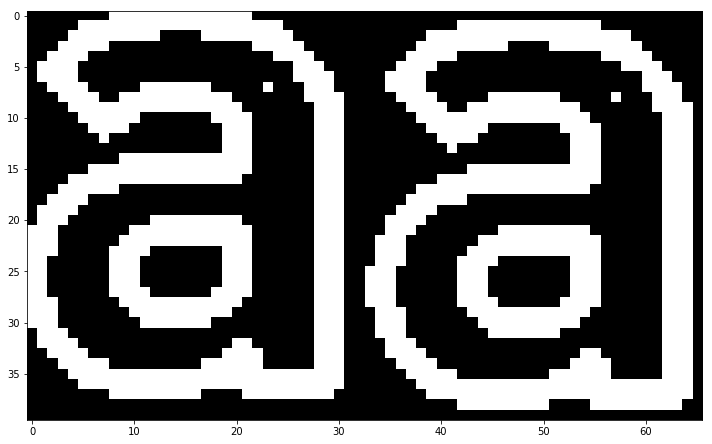

In [16]:
# A dilation followed by an erosion is also called 'closing'
jax_closing = morphology.closing(jax_outline, selem=selem)

# Lets compare dilation->erosion (left) to closing (right)
image_row_1 = jax_dilate_erode[175:215, 632:665]
image_row_2 = jax_closing[175:215, 632:665]

image_row = np.hstack((image_row_1, image_row_2))

io.imshow(image_row);

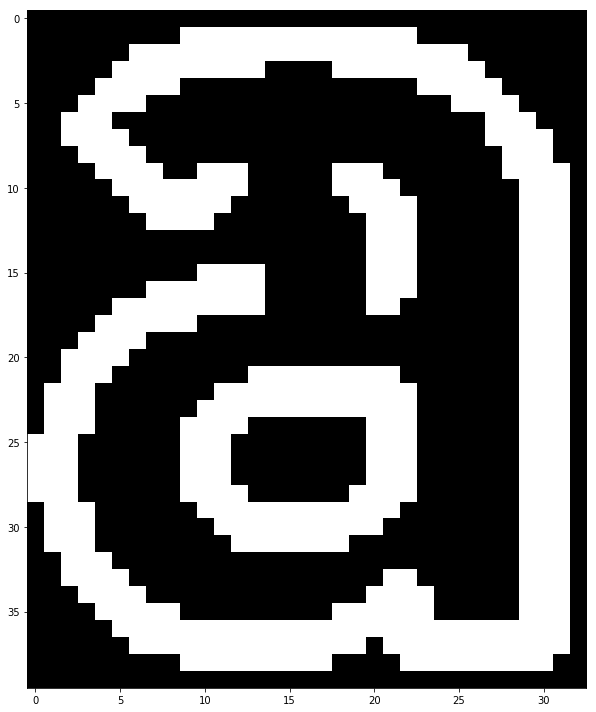

In [17]:
# an erosion followed by a dilation is called 'opening'
jax_opening = morphology.opening(jax_outline, selem=selem)

io.imshow(jax_opening[175:215, 632:665]);

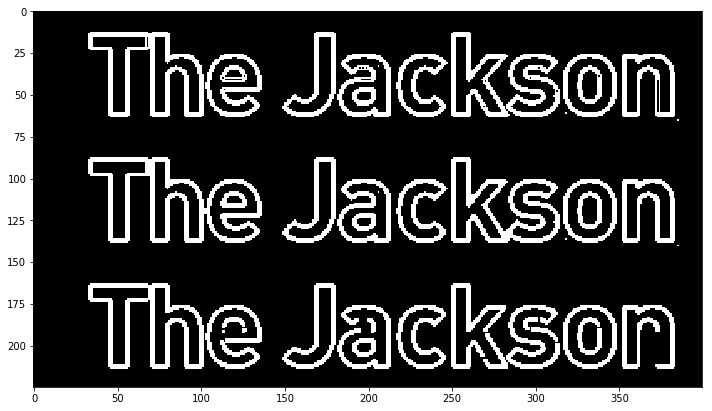

In [18]:
# In this case, closing cleared out some gaps in the letters, but left a little noise
# opening got rid of noise, but deleted some of the outline

image_row_1 = jax_outline[150:225, 450:850]
image_row_2 = jax_closing[150:225, 450:850]
image_row_3 = jax_opening[150:225, 450:850]

image_row = np.vstack((image_row_1, image_row_2, image_row_3))

io.imshow(image_row);

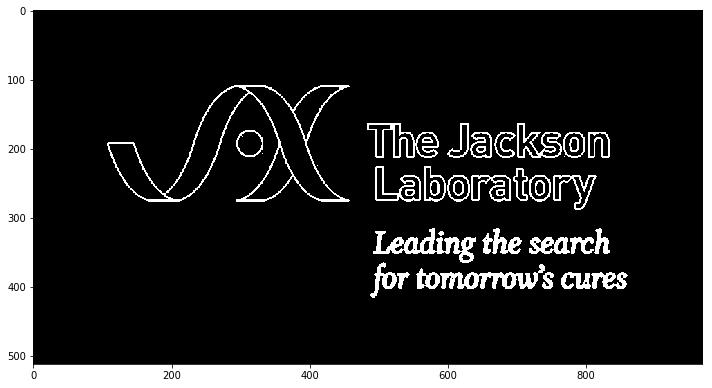

In [19]:
io.imshow(jax_closing);

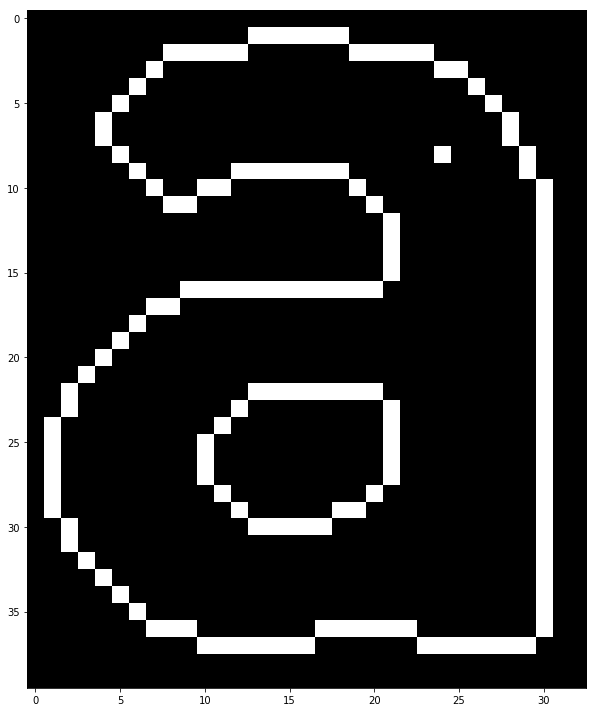

In [20]:
# skeletonize will pare back to a one-pixel-wide line
jax_skeleton = morphology.skeletonize(jax_closing)
io.imshow(jax_skeleton[175:215, 632:665]);

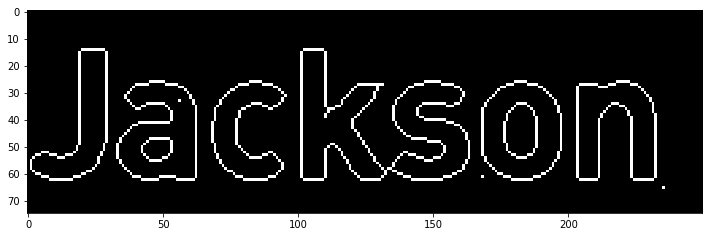

In [21]:
# Note that sometimes the Jupyter rendering looks a little weird
# 'Jackson' looks okay here

io.imshow(jax_skeleton[150:225, 600:850]);

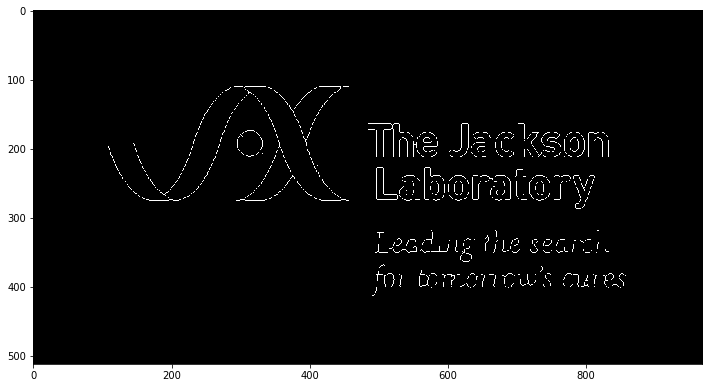

In [22]:
# But 'Jackson' (and everything else) looks bad here, even though we know it's okay
# This is a Jupyter issue.

io.imshow(jax_skeleton);

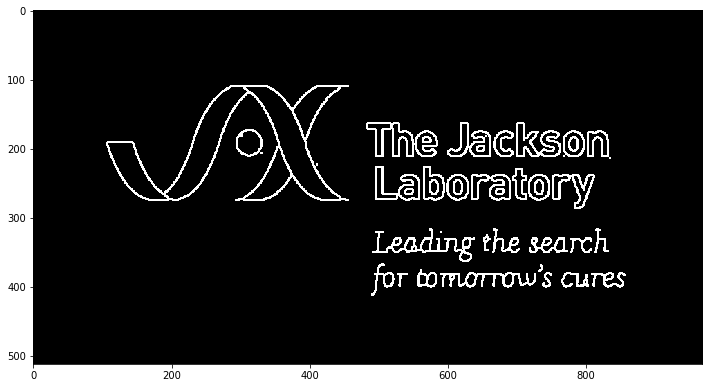

In [23]:
# Thicken skeleton with two rounds of dilation

jax_bordermask = morphology.dilation(jax_skeleton, selem=selem)
jax_bordermask = morphology.dilation(jax_bordermask, selem=selem)
io.imshow(jax_bordermask);

## Some things to do with binary masks

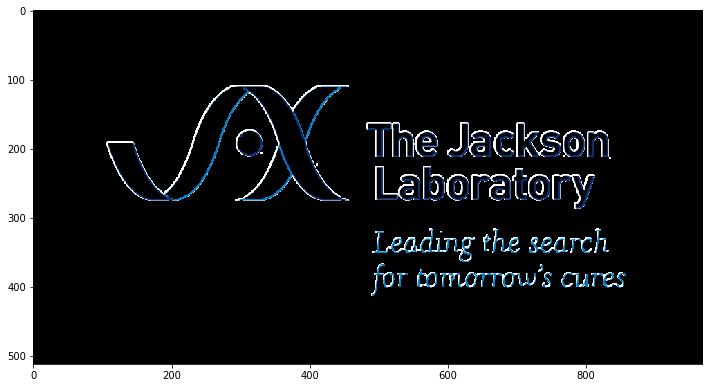

In [24]:
# Binary images can also be used to mask other images
# For example, lets make a new image that takes pixels from the original jax image
# only where we have created our nice outline (jax_bordermask)

jax_color_outline = jax.copy()

# note: you have to do this for all three color channels!
jax_color_outline[:,:,0] = jax_bordermask * jax[:,:,0] 
jax_color_outline[:,:,1] = jax_bordermask * jax[:,:,1]
jax_color_outline[:,:,2] = jax_bordermask * jax[:,:,2]

io.imshow(jax_color_outline);

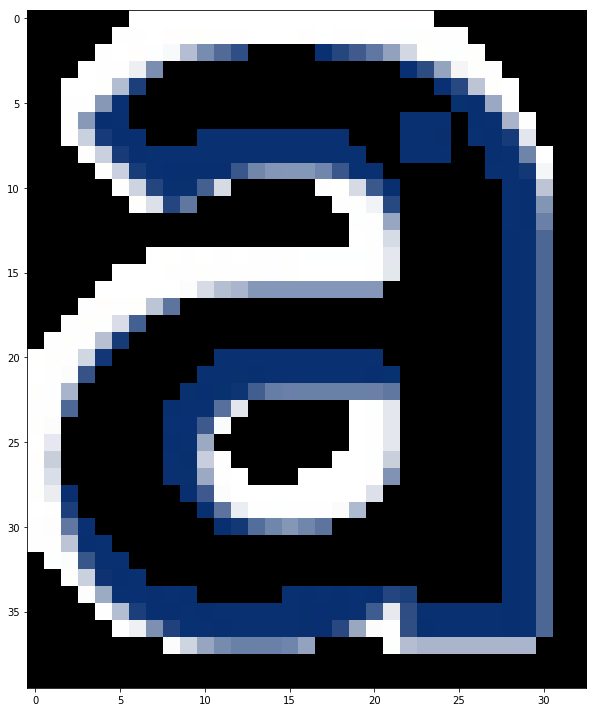

In [25]:
# Here we can see our outline actually lines up pretty well with the original letters

io.imshow(jax_color_outline[175:215, 632:665]);

----
## Slides covering connectivity-based segmentation
---

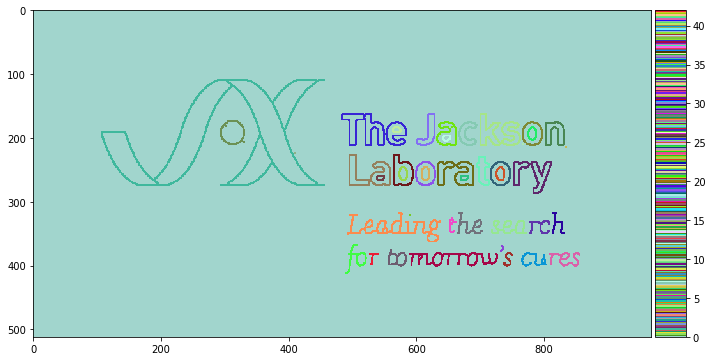

In [28]:
# we can also find all connected regions in a binary mask
# This is very useful for finding and counting objects
jax_label = measure.label(jax_bordermask)

# this is to randomly color our labels (rerun for a different map)
random_cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3)) 

io.imshow(jax_label, cmap=random_cmap);

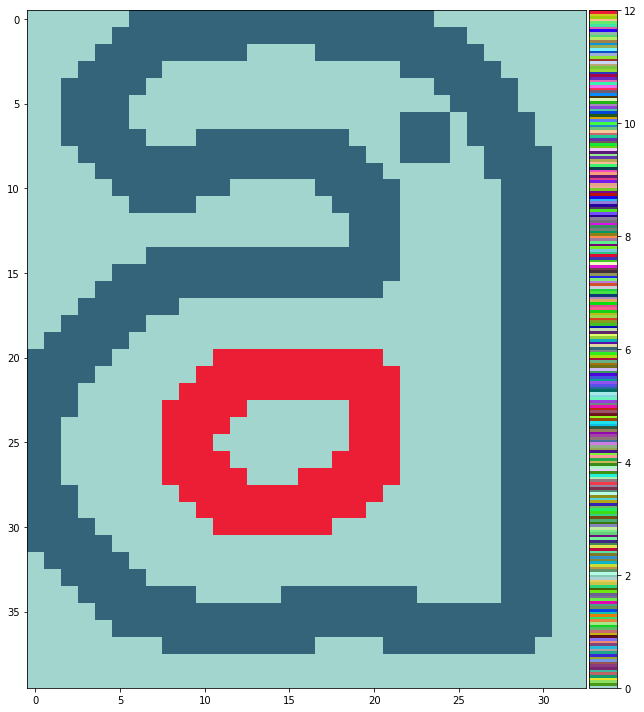

In [29]:
io.imshow(jax_label[175:215, 632:665], cmap=random_cmap); 

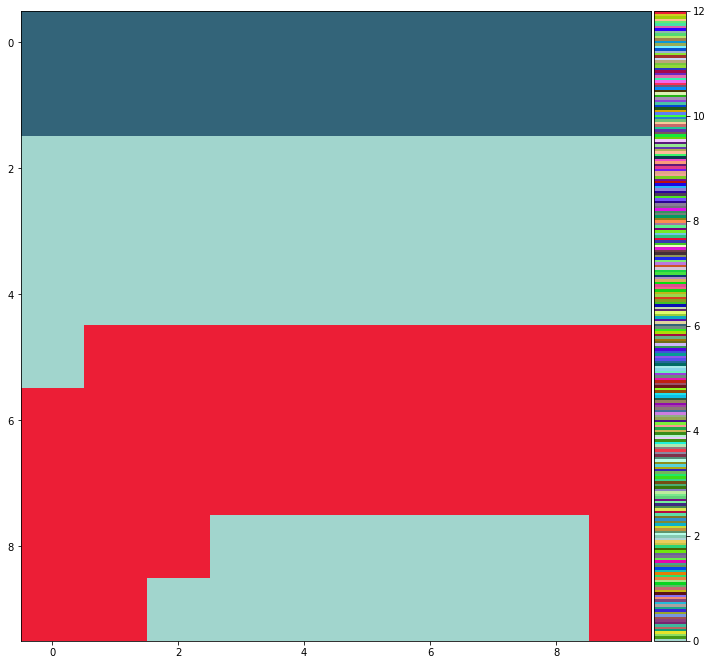

In [30]:
io.imshow(jax_label[190:200, 642:652], cmap=random_cmap);

In [31]:
jax_label[190:200, 642:652]

array([[ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12,  0,  0,  0,  0,  0,  0, 12],
       [12, 12,  0,  0,  0,  0,  0,  0,  0, 12]])

In [32]:
jax_label.max()

42

In [33]:
np.where(jax_label == 42)

(array([380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381,
        381, 381, 381, 381, 381, 381, 381, 382, 382, 382, 382, 382, 382,
        382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383,
        383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383,
        384, 384, 384, 384, 385, 385, 385, 386, 386, 386, 387, 387, 387,
        387, 388, 388, 388, 388, 389, 389, 389, 390, 390, 390, 391, 391,
        391, 392, 392, 392, 393, 393, 393, 394, 394, 394, 395, 395, 395,
        396, 396, 396, 396, 397, 397, 397, 397, 398, 398, 398, 398, 399,
        399, 399]),
 array([527, 528, 529, 530, 526, 527, 528, 529, 530, 531, 532, 533, 534,
        535, 536, 537, 538, 539, 540, 541, 526, 527, 528, 529, 530, 531,
        532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 526, 527, 528,
        529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
        530, 531, 532, 533, 530, 531, 532, 530, 531, 532, 529, 530, 531,
        532, 529, 530, 531, 532

## Exercise

1. Create a new image from the "coins" example in scikit-image
```python
from skimage import data
coins = data.coins()
```
2. Write something to automatically count the number of coins. This does not have to be perfect! You can do a decent job using only what you have learned in this workshop.

## Finally...
If you complete the coin exercise without too much trouble, try it again with data/cells.tif!
Using only what we have learned in this workshop, can you write something to estimate cell counts?